# <center>Audio Emotion Recognition</center>
## <center>Part 4 - Apply to new audio data</center>
#### <center> 31st August 2019 </center> 
#####  <center> Eu Jin Lok </center> 

## Introduction 
In [part 3](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model) we built a simple baseline model and we serialise it. We also have an early indication of the accuracy to be expected across the 3 models namely 

- Gender at __81%__ absolute accuracy<br/>
- Emotion at __50%__ absolute accuracy<br/>
- Gender and Emotion at __43%__ absolute accuracy <br/>

So whilst it's all well and good in our little sandbox experiment here, question remains how well will it generalise across new unseen data? The accuracy measurement that we recorded above is based on the same dataset. Whilst we ensured the accuracy measure is based on a slice of the data that the model hasn't seen before, it is still made from the data source that will include the same speaker voice, the same audio quality, audio background etc. The model we trained could very well have picked up speakers unique characteristics rather than the audio features (data leakage). So how will this model perform once we apply it to a completely new dataset with different audio quality, speaker and background noises? It is here which we will run a quick test where I will record a new audio file and run it through the model  


1. [Audio Recording](#audio)
2. [Data preparation and prediction](#data)
3. [Final thoughts](#final)

Upvote this notebook if you like, and be sure to check out the other parts which are now available:
* [Part 5 | Data augmentation](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation)

Most importantly, I want to thank the 4 authors for their excellent dataset, without it, writing this notebook could not have been possible. The original source of the dataset links are below:

- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)

In [1]:
# Importing required libraries 
from keras.models import Sequential, Model, model_from_json
import matplotlib.pyplot as plt
import keras 
import pickle
import wave  # !pip install wave
import os
import pandas as pd
import numpy as np
import sys
import warnings
import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

<a id="audio"></a>
## 1. Audio recording 
I've used python itself to run the audio recorder and recorded a track using my wife's voice. However to record the audio, you need a microphone and is not possible to do this on Kaggle itself. So I've had to prerecord the audio and host it on this notebook. But I've provided the code below to run the recording, it opens up an audio channel for 4 seconds of recording before saving it as a WAV file. Remember your computer needs to be connected to a microphone audio source for it to work.

```python
CHUNK = 1024 
FORMAT = pyaudio.paInt16 
CHANNELS = 2 
RATE = 44100 
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "test audio\\testing.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()
```

--------------------------------
So the this audio file below is a pre-recorded audio file which we will use to test the model. I've recorded this using the pyaudio code above, and uploaded it here on this notebook. You can download it to reproduce the results. Lets play the file and see how the wave plot looks like...

In [2]:
# data, sampling_rate = librosa.load('/kaggle/input/gfvoice/WhatsApp Ptt 2024-05-26 at 18.59.31.wav')
# # ipd.Audio('/kaggle/input/gfvoice/WhatsApp Ptt 2024-05-26 at 18.59.31.wav')

# data, sampling_rate = librosa.load('/kaggle/input/gfvoice2/WhatsApp Ptt 2024-05-26 at 19.15.17.wav')
# ipd.Audio('/kaggle/input/gfvoice2/WhatsApp Ptt 2024-05-26 at 19.15.17.wav')

data, sampling_rate = librosa.load('/kaggle/input/emergency/WhatsApp Ptt 2024-05-27 at 12.09.25.wav')
ipd.Audio('/kaggle/input/emergency/WhatsApp Ptt 2024-05-27 at 12.09.25.wav')

# data, sampling_rate = librosa.load('/kaggle/input/gfvoice3/WhatsApp Ptt 2024-05-26 at 19.42.33.wav')
# ipd.Audio('/kaggle/input/gfvoice3/WhatsApp Ptt 2024-05-26 at 19.42.33.wav')

# data, sampling_rate = librosa.load('/kaggle/input/gfvoice4/WhatsApp Ptt 2024-05-26 at 19.50.28.wav')
# ipd.Audio('/kaggle/input/gfvoice4/WhatsApp Ptt 2024-05-26 at 19.50.28.wav')

# data, sampling_rate = librosa.load('/kaggle/input/gfvoice5/WhatsApp Ptt 2024-05-26 at 19.50.50.wav')
# ipd.Audio('/kaggle/input/gfvoice5/WhatsApp Ptt 2024-05-26 at 19.50.50.wav')

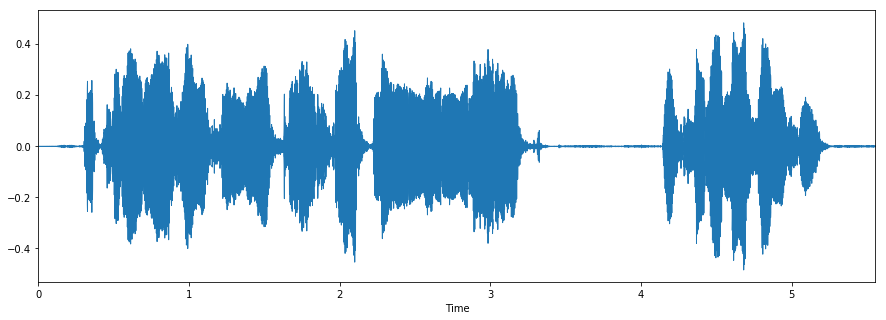

In [3]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

<a id="data"></a>
## 2. Data preparation and prediction
So what we're aiming for is __female_happy__ prediction as the correct answer. Now that we have the audio file ready, we'll need to convert it to the correct data format for our model, and we'll need the serialised models for the weights and the model architecture that we performed in [part 3](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model). I'm not going to re-run the entire code just to get the files, so what I've done is downloaded the 'model_json.json' and 'Emotion_Model.h5' files and loaded it into this notebook. 

In [4]:
# loading json and model architecture 
json_file = open('/kaggle/input/jsonnn/model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/kaggle/input/modell/Emotion_Model.h5")
print("Loaded model from disk")

# the optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


And next step transform the audio data...

In [5]:
# Lets transform the dataset so we can apply the predictions
X, sample_rate = librosa.load('/kaggle/input/emergency/WhatsApp Ptt 2024-05-27 at 12.09.25.wav'
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
newdf = pd.DataFrame(data=mfccs).T
newdf

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-2.246851,-6.74252,-21.339542,-19.831503,-16.864748,-15.363362,-12.52778,-10.444963,-10.30866,-13.824108,...,-9.589294,-6.553953,-5.340085,-4.54157,-5.230136,-3.930861,-6.513647,-9.996929,-5.468213,-0.635816


And finally run the predictions over it using our saved baseline model

In [6]:
# Apply predictions
newdf= np.expand_dims(newdf, axis=2)
newpred = loaded_model.predict(newdf, 
                         batch_size=16, 
                         verbose=1)

newpred

1/1 [==============================] - 0s 309ms/step


array([[4.2685971e-14, 1.7611082e-07, 1.5389934e-06, 1.3607160e-10,
        6.4469313e-22, 1.4609103e-10, 9.9999833e-01, 7.8945668e-17,
        3.1372099e-11, 1.0038344e-10, 4.2106340e-14, 5.4044883e-18,
        8.4378260e-12, 1.3649099e-12]], dtype=float32)

--------------------
The prediction is in the form of numbers, we'll need to append the labels to it before we can make sense as to what it has predicted... The labels code can be found again, in part 3, but instead of re-running it, i've just uploaded the file into this notebook. Its simple a mapping file between the labels and the ID pairs.

In [7]:
filename = '/kaggle/input/labell/labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

# Get the final predicted label
final = newpred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final) #emo(final) #gender(final) 

['female_surprise']


<a id="final"></a>
## 3. Final thoughts
So our model predicted __female surprise__, which on hindsight, going back listening to the audio again, I would actually agree with the prediction! Even thou I gave specific instructions to my wife to record a happy audio, I suppose the emotion exhibited is very similar to suprise. This is a very pleasant surprise indeed.  

In our next section we will be looking to enhance the model!